## Choosing hyperparameters for GAiA's neural network

In this notebook, we are trying different numbers of SE-ResNet blocks for our final model.

In [1]:
from model.GAiA_network import GAiA_Network, MAE, coefficient_determination
from lib.dataset_utils import read_many_hdf5, board_shape
from lib.torch_model_wrapper import TorchWrapper

import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

import platform
if platform.system() == "Darwin":
  %config InlineBackend.figure_format="retina"  # For high DPI display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We are loading our training dataset and we are using it to build different training and validation data
for each model.

In [3]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
positions, scores = read_many_hdf5(992453, directory, "_train")
positions = positions[:500000]
scores = scores[:500000]

nb_models = 6
positions_train, scores_train = [], []
positions_valid, scores_valid = [], []
for i in range(nb_models):
  positions_train_t, positions_valid_t, scores_train_t, scores_valid_t = train_test_split(
    positions, scores, test_size=0.2, random_state=42+i)
  positions_train.append(positions_train_t.transpose((0, 3, 1, 2))) # Channel first
  positions_valid.append(positions_valid_t.transpose((0, 3, 1, 2))) # Channel first
  scores_train.append(scores_train_t.reshape(-1, 1))
  scores_valid.append(scores_valid_t.reshape(-1, 1))
print(f"Training sets shape ≈ {positions_train[0].shape}, Validation sets shape ≈ {positions_valid[0].shape}")


Training sets shape ≈ (400000, 15, 8, 8), Validation sets shape ≈ (100000, 15, 8, 8)


Now, we create several networks with an increasing number of SE-ResNet blocks.

In [4]:
networks = []
offset_blocks = 2
filters = [64, 128]
loss_function = MAE
for i in range(1, nb_models+1):
  network = GAiA_Network(board_shape, filters=filters[(i-1) // (nb_models//2)], nb_blocks=i+offset_blocks)
  network.to(device)
  optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
  twrapper = TorchWrapper(network, device, optimizer, loss_function, coefficient_determination)
  networks.append(twrapper)

We train our models.

In [5]:
nb_epochs = 15
histories = []
for i, network in enumerate(networks):
  print(f"Model {i+1}/{len(networks)}...", end=" ")
  history = network.fit(positions_train[i], scores_train[i], verbose=False, epochs=nb_epochs, batch_size=1024)
  histories.append(history)
  accuracy = history["metric"][-1]
  print(f"Done. Training accuracy: {accuracy:.2f}")

Model 1/6... Done. Training accuracy: 0.51
Model 2/6... Done. Training accuracy: 0.75
Model 3/6... Done. Training accuracy: 0.67
Model 4/6... Done. Training accuracy: 0.80
Model 5/6... Done. Training accuracy: 0.79
Model 6/6... Done. Training accuracy: 0.84


In [19]:
def coefficient_determination(y_true, y_pred):
  nom = np.sum(np.square(y_true - y_pred))
  denom = np.sum(np.square(y_true - np.mean(y_true)))
  return 1 - nom / denom

def plot_validation_results(histories, validation_Xs, validation_ys, path=None, ext="pdf"):
  epochs = range(1, nb_epochs + 1)

  f, axs = plt.subplots(1, 2, figsize=(20, 5))
  _, ax_score  = plt.subplots(1, 1, figsize=(10, 5))

  line_styles = ["-", "--", "-.", ":", ".-"]

  for i, history in enumerate(histories):
    X_valid = validation_Xs[i]
    y_valid = validation_ys[i]
    nb_blocks = i + offset_blocks + 1
    nb_filters = filters[i // (nb_models//2)]

    loss = history["loss"]
    score = history["metric"]
    style = line_styles[i % len(line_styles)]
    axs[0].plot(epochs, loss, style, label=f"{nb_blocks} SE-ResNet blocks {nb_filters} filters")

    axs[1].plot(epochs, score, style, label=f"{nb_blocks} SE-ResNet blocks {nb_filters} filters")

    preds = networks[i].predict(X_valid)
    r2_score = coefficient_determination(y_valid, preds)
    ax_score.scatter(y_valid, preds, label = f"{nb_blocks} SE-ResNet blocks  {nb_filters} filters $R^2 = {r2_score:.2f}$")


  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("(Mean Absolute Error)")
  axs[0].set_title('Training loss')
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("($R^2$)")
  axs[1].set_title('Training score')
  for ax in axs:
    ax.legend()

  if path:
    f.savefig(path + "_1." + ext)

  ma = np.max(y_valid)
  mi = np.min(y_valid)
  x = np.linspace(ma, mi, 100)
  ax_score.plot(x, x, "-.", label = "Predictions = True values")
  ax_score.set_xlabel("True values (centipawn)")
  ax_score.set_ylabel("Predictions (centipawn)")
  ax_score.set_title("Results on validation set")
  ax_score.legend()

  if path:
    plt.savefig(path + "_2." + ext)

Here are the results!

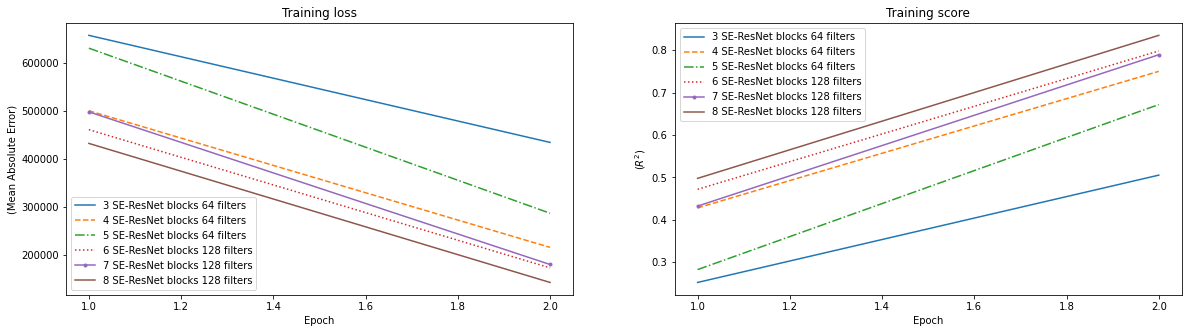

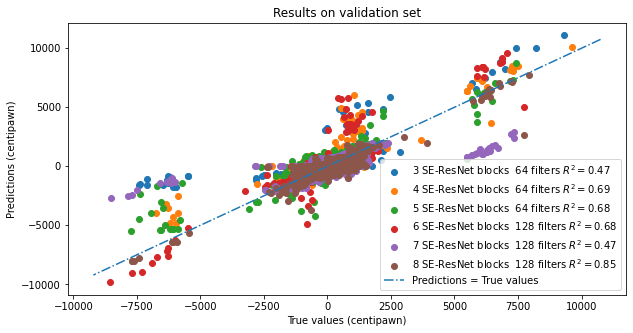

In [20]:
plot_validation_results(histories, positions_valid, scores_valid, path="results/model_selection")

We can see on the figure above that all of our model perform well.

However, adding more blocks and filters do not improve the results.

Therefore, we can take a not too complex one.

In [ ]:
config = {"nb_blocks": 4, "filters": 64}
print(config)
output_file = open("model/hyperparameters.pickle", "wb")
pickle.dump(config, output_file)
output_file.close()

{'nb_blocks': 4, 'filters': 64}
